In [1]:
import pandas as pd

In [ ]:
import pandas as pd
import statsmodels.api as sm

# Read the CSV file into a pandas DataFrame
filename = "recommendations_output_file.csv"
#change this to the output file generated by the evaluation model
df = pd.read_csv(filename)




In [ ]:
# check mean of similarity score for a given author
x = df.groupby('recommended_to')['similarity_score'].mean()
y = x.to_frame()

In [ ]:
# check number of authors
len(df['recommended_to'].unique())

1128

# Preprocessing

In [ ]:
# column renamed for processing
df.rename(columns=lambda x: x.replace(' ', '_'), inplace=True)
df.columns

Index(['Unnamed:_0', 'id', 'title', 'authors', 'abstract', 'authors_parsed',
       's2PaperId', 'corpusId', 'year', 'recommended_to',
       'number_of_papers_trained_on', 'similarity_score', 'References_Author',
       'Also_Authored_by_input_author', 'Citations_Present'],
      dtype='object')

In [11]:
df['References_Author'] = df['References_Author'].astype(int)
df["Also_Authored_by_input_author"] = df["Also_Authored_by_input_author"].astype(int)

In [12]:
df["Citations_Present"] = df["Citations_Present"].replace('No Citations', 0) 
df["Citations_Present"] = df["Citations_Present"].replace('True', 1) 

/var/folders/6t/n15n56yj72x3s3n9qpvjb1c80000gn/T/ipykernel_39205/1102778795.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["Citations_Present"] = df["Citations_Present"].replace('True', 1)


In [15]:
# create a column that normalizes similarity score by the mean score for that recommended_to
df['similarity_score_normalized'] = df.groupby('recommended_to')['similarity_score'].transform(lambda x: (x - x.mean()) / x.std())

# create a column that ranks similarity for each recommended_to
df['similarity_score_percentile'] = df.groupby('recommended_to')['similarity_score'].rank(ascending=True) # higher rank means higher similarity, to be consistent sign wise
df['similarity_score_percentile']/= max(df['similarity_score_percentile'])

In [16]:
df.head()

,Unnamed:_0,id,title,authors,abstract,authors_parsed,s2PaperId,corpusId,year,recommended_to,number_of_papers_trained_on,similarity_score,References_Author,Also_Authored_by_input_author,Citations_Present,similarity_score_normalized,similarity_score_percentile
0,0,1812.01569,Nested Reasoning About Autonomous Agents Using...,"Iris Rubi Seaman, Jan-Willem van de Meent, Dav...","As autonomous agents become more ubiquitous,...","[['Seaman', 'Iris Rubi', ''], ['van de Meent',...",36538516de0800384e96c0ce3bbe3b4ba966c9e1,212415193.0,2018.0,Frans A. Oliehoek,13,0.817741,0,0,0,3.180080,1.0000
1,1,2006.07532,Online Bayesian Goal Inference for Boundedly-R...,"Tan Zhi-Xuan, Jordyn L. Mann, Tom Silver, Josh...",People routinely infer the goals of others b...,"[['Zhi-Xuan', 'Tan', ''], ['Mann', 'Jordyn L.'...",82a8b7164f377c139e848986a2980a6678aa6cd3,219687443.0,2020.0,Frans A. Oliehoek,13,0.814946,0,0,0,3.133102,0.9995
2,2,2010.11835,Multi-agent active perception with prediction ...,Mikko Lauri and Frans A. Oliehoek,Multi-agent active perception is a task wher...,"[['Lauri', 'Mikko', ''], ['Oliehoek', 'Frans A...",090ebc2d27ed89933b08fbe87e79fc32bb4785e5,225039876.0,2020.0,Frans A. Oliehoek,13,0.810418,1,1,0,3.056984,0.9990
3,3,2007.05647,Finding Equilibrium in Multi-Agent Games with ...,"Wenshuo Guo, Mihaela Curmei, Serena Wang, Benj...",We study the problem of finding equilibrium ...,"[['Guo', 'Wenshuo', ''], ['Curmei', 'Mihaela',...",1ee6415f6bbf3471e7593f5b54b2451bfcc848ee,220495737.0,2020.0,Frans A. Oliehoek,13,0.805780,0,0,0,2.979023,0.9985
4,4,2002.10185,iLQGames.jl: Rapidly Designing and Solving Dif...,"Lasse Peters, Zachary N. Sunberg",In many problems that involve multiple decis...,"[['Peters', 'Lasse', ''], ['Sunberg', 'Zachary...",dbd5c077d748ebb397daad67f6e613f92c3a1d47,211258967.0,2020.0,Frans A. Oliehoek,13,0.798043,0,0,0,2.848971,0.9980


In [17]:
authors_referenced = df.groupby('recommended_to')['References_Author'].sum().reset_index()
authors_referenced_set = authors_referenced.query('References_Author > 0').recommended_to.unique()
df_only_referenced_authors = df.query('recommended_to in @authors_referenced_set')
df_only_referenced_authors.recommended_to.nunique()

882

# look at some summary statistics

In [ ]:
dftodo = df

In [ ]:
simcols = ['similarity_score', 'similarity_score_percentile', 'similarity_score_normalized'] 
eval_cols = ['References_Author', 'Citations_Present', 'Also_Authored_by_input_author']

dftodo[simcols].describe()

,similarity_score,similarity_score_percentile,similarity_score_normalized
count,2.256000e+06,2.256000e+06,2.256000e+06
mean,6.127947e-01,5.002500e-01,-2.630520e-17
std,6.977936e-02,2.886752e-01,9.997502e-01
min,2.966557e-01,5.000000e-04,-4.795937e+00
25%,5.655550e-01,2.502500e-01,-6.983075e-01
50%,6.108565e-01,5.002500e-01,-3.737346e-02
75%,6.583735e-01,7.502500e-01,6.780604e-01
max,9.854246e-01,1.000000e+00,5.961653e+00


In [ ]:
dftodo[eval_cols].sum() #also_authored is sparse

References_Author                10289
Citations_Present                 3153
Also_Authored_by_input_author     1238
dtype: int64

In [21]:
dftodo[eval_cols].describe()

,References_Author,Citations_Present,Also_Authored_by_input_author
count,2.256000e+06,2.256000e+06,2.256000e+06
mean,4.560727e-03,1.397606e-03,5.487589e-04
std,6.737899e-02,3.735845e-02,2.341918e-02
min,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00
50%,0.000000e+00,0.000000e+00,0.000000e+00
75%,0.000000e+00,0.000000e+00,0.000000e+00
max,1.000000e+00,1.000000e+00,1.000000e+00


In [22]:
dftodo.groupby('Citations_Present')[simcols].mean()

,similarity_score,similarity_score_percentile,similarity_score_normalized
Citations_Present,,,
0,0.612678,0.499825,-0.001767
1,0.696291,0.803641,1.262704


In [23]:
dftodo.groupby('References_Author')[simcols].mean()

,similarity_score,similarity_score_percentile,similarity_score_normalized
References_Author,,,
0,0.612397,0.498891,-0.005418
1,0.699609,0.796941,1.182465


In [24]:
dftodo.groupby('Also_Authored_by_input_author')[simcols].mean()

,similarity_score,similarity_score_percentile,similarity_score_normalized
Also_Authored_by_input_author,,,
0,0.612734,0.500056,-0.000926
1,0.723005,0.853712,1.686298


# Plot Similarity Score Histograms

In [26]:
import seaborn as sns

In [27]:
dftodo.rename(columns={'Citations_Present': 'Author cites paper'}, inplace=True)

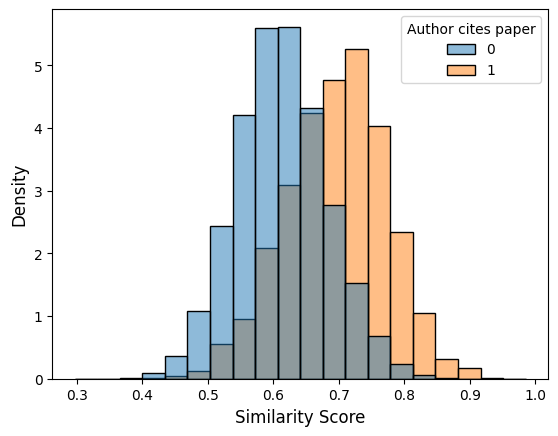

In [28]:
import matplotlib.pyplot as plt
sns.histplot(dftodo, x='similarity_score', hue='Author cites paper', bins=20, stat = 'density', common_norm = False)
plt.xlabel('Similarity Score', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.savefig('sim_score_density_mean_transformer.pdf')

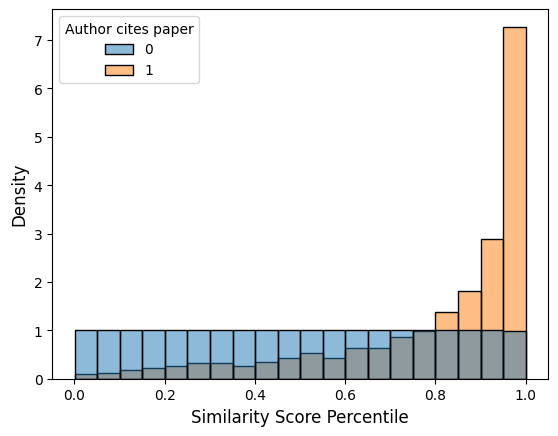

In [30]:
sns.histplot(dftodo, x='similarity_score_percentile', hue='Author cites paper', bins=20, stat = 'density', common_norm = False)
plt.xlabel('Similarity Score Percentile', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.savefig('sim_score_density_perc_mean_transformer.pdf')

In [32]:
dftodo.rename(columns={'Author cites paper':'Citations_Present'}, inplace=True)

# Regresssion evaluation

In [33]:
import statsmodels.formula.api as smf

def print_results_summary(formula, data = dftodo):
    model = smf.logit(formula=formula, data=data)

    # Fit the model to the data
    results = model.fit()
    
    #extract the coefficients and p values
    coefs = results.params
    pvals = results.pvalues
    

    # Print the summary of the regression results
    print(results.summary())
    
    return coefs.reset_index(), pvals.reset_index()

In [34]:
dic = {}
for col in eval_cols:
    for simcol in simcols:
        print(col, simcol)
        formula = col + ' ~ ' + simcol
        c, p = print_results_summary(formula)
        
        # add all coefficients and p values to a dataframe 
        print(c)
        
        dic['evalcol'] = dic.get('evalcol', [])
        dic['evalcol'].append(col)
        dic['simcol'] = dic.get('simcol', [])
        dic['simcol'].append(simcol)
        for i, row in c.iterrows():
            colname = row["index"].replace(simcol, 'simcol')
            
            dic[f'coef_{colname}'] = dic.get(f'coef_{colname}', [])
            dic[f'coef_{colname}'].append(row[0])
            
            dic[f'pval_{colname}'] = dic.get(f'pval_{colname}', [])
            dic[f'pval_{colname}'].append(p.iloc[i][0])

References_Author similarity_score
Optimization terminated successfully.
         Current function value: 0.025721
         Iterations 10
                           Logit Regression Results                           
Dep. Variable:      References_Author   No. Observations:              2256000
Model:                          Logit   Df Residuals:                  2255998
Method:                           MLE   Df Model:                            1
Date:                Wed, 03 Jul 2024   Pseudo R-squ.:                  0.1171
Time:                        00:15:02   Log-Likelihood:                -58027.
converged:                       True   LL-Null:                       -65726.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept          -16.5950      0.098   -169.808      0.000